#### For volcano plot (pre vs. post tratment in drug sensitive sarcoma patients) in Figure 5

In [47]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import colors
import os
from numpy import ma
import seaborn as sns
%matplotlib inline
from scipy import stats
from scipy.stats import zscore
from sklearn.decomposition import PCA
from natsort import natsorted
import ipywidgets
from glob import glob
import logging
import sys
import pingouin as pg
from statsmodels.stats.weightstats import ttest_ind
from statistics import mean
from scipy.stats import t

In [48]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure4 data_SenstiveResistant')

In [49]:
# import data from github

dfSarcoma = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls/MQ/vanTine_001_90_samples/Protein/Model/Protein_pVals_Final_WithMetaData.xlsx', sheet_name='Sheet1')

In [50]:
parser = 'group'

In [51]:
# Filter for the analysis

df = dfSarcoma
dataTypeFilter = 'NormalizedIntensity_Log2'
    
df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
df = df.query("dataType == @dataTypeFilter")

df = df.query("timing != 'Control' and sensitivity == 'S'") # sensitive

totalCols = df.columns
numCols = df._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

df = pd.melt(df,
    id_vars = catCols,
    value_vars = numCols,
    var_name = 'protAcc',
    value_name="area",
    ignore_index=False,
    )

#remove rows without areas & duplicates
df.dropna(subset=['area'], inplace=True)
df.drop_duplicates(inplace = True)

# add a column specifying the dataset
dataset = 'sarcoma'
df.insert(loc=1, column='dataset', value=dataset)

dfProtein = df
dfProtein.head()

,timing,dataset,race,sensitivity,gender,sample,patient,cancer,cancerType,dataType,age,group,protAcc,area
11,Pre,sarcoma,WHITE,S,M,BJW.S.Pre,BJW,c,EPI,NormalizedIntensity_Log2,30-39,S.Pre,A0A075B6H7,1.639
20,Post,sarcoma,WHITE,S,F,BNN.S.Post,BNN,c,MPNST,NormalizedIntensity_Log2,70-79,S.Post,A0A075B6H7,-1.775
26,Post,sarcoma,WHITE,S,M,BPE.S.Post,BPE,c,LS,NormalizedIntensity_Log2,60-69,S.Post,A0A075B6H7,-0.856
27,Pre,sarcoma,WHITE,S,M,BPE.S.Pre,BPE,c,LS,NormalizedIntensity_Log2,60-69,S.Pre,A0A075B6H7,0.830
28,Post,sarcoma,WHITE,S,F,BPV.S.Post,BPV,c,LS,NormalizedIntensity_Log2,50-59,S.Post,A0A075B6H7,0.643


#### annotate merged long/tidy data with uniprot IDs (or other metadata)

In [52]:
# make dfUniprot for annotation, this excel file is on the associated GitHub page

dfUniprot = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure2_Data_CancerVsNormal/uniprot-download_true_fields_accession_2Creviewed_2Cid_2Cprotein_nam-2023.03.17-19.33.16.44.xlsx')
dfUniprot = dfUniprot.rename(columns={'Entry' : 'protAcc'})
dfUniprot = dfUniprot.rename(columns={'Gene Names (primary)' : 'geneNamePrimary'})
dfUniprot = dfUniprot.drop(columns=['Length','Entry Name','Organism','Gene Names'])
dfUniprot['protAcc'] = dfUniprot['protAcc'].astype(str)
dfUniprot.drop_duplicates(subset=['protAcc'], inplace = True)
dfUniprot

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,protAcc,Reviewed,Protein names,geneNamePrimary
0,A0A075B6G3,unreviewed,Dystrophin,DMD
1,A0A087WV00,unreviewed,Diacylglycerol kinase (DAG kinase) (EC 2.7.1.107),DGKI
2,A0A087WZT3,unreviewed,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6
3,A0A087X1C5,reviewed,Putative cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7
4,A0A0A0MQU7,unreviewed,HNF1 homeobox A,HNF1A
...,...,...,...,...
81786,X6RLU5,unreviewed,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4
81787,X6RLV5,unreviewed,DEAD-box helicase 5,DDX5
81788,X6RLY7,unreviewed,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4
81789,X6RM00,unreviewed,ELKS/RAB6-interacting/CAST family member 1,ERC1


In [54]:
# annotate uniprot info
dfMerged = dfProtein.merge(dfUniprot, on='protAcc', how='left')

totalCols = dfMerged.columns
numCols = dfMerged._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

dfMerged['area'] = dfMerged['area'].astype(float)

In [55]:
# remove Remove 'crapome' proteins

crapome =['KRT1', 'KRT2', 'KRT3', 'KRT4', 'KRT5', 'KRT6', 'KRT7', 'KRT8', 'KRT9', 'KRT10', 'KRT11', 'KRT12', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17', 'KRT18', 'KRT19', 'KRT20', 'KRT21', 'KRT22', 'KRT23', 'KRT24']

dfMerged = dfMerged.loc[~dfMerged['geneNamePrimary'].str.contains('|'.join(crapome))]

In [56]:
# count protein IDs

dfTemp = dfMerged

nSamplesFilter = 10
nSamplesControlOnlyFilter = 0
    
#drop 0 values
dfTemp.dropna(subset = ['area'], inplace = True)

# count
dfTemp['nSamples'] = dfTemp.groupby('protAcc')['protAcc'].transform('count')
nSamplesControlOnly = dfTemp.query('cancer == "n"').groupby('protAcc')['protAcc'].agg('count').to_frame()
nSamplesControlOnly.rename(columns = {'protAcc' : 'nSamplesControlOnly'}, inplace = True)
dfTemp = dfTemp.join(nSamplesControlOnly, on = 'protAcc')
dfTemp['nSamplesControlOnly'] = dfTemp['nSamplesControlOnly'].fillna(0)

# filter by N detections
dfTemp = dfTemp.query('nSamples >= @nSamplesFilter')
dfTemp = dfTemp.query('nSamplesControlOnly >= @nSamplesControlOnlyFilter')

dfFiltered = dfTemp

In [57]:
# find and select data/feature columns

totalCols = dfFiltered.columns
numCols = dfFiltered._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

# pivot 
dfStatsPre = dfFiltered.pivot_table(
    values = 'area',
    index = [parser,'sample'],
    columns = ['geneNamePrimary'],
).reset_index().rename_axis(None, axis=1)
dfStatsPre.set_index(parser, inplace = True)

dfStatsPre.reset_index(inplace = True)
sampleNames = dfStatsPre['sample']
dfStatsPre = dfStatsPre.drop(columns = ['sample'])

# impute nan to min value in column

for col in dfStatsPre.columns:
    dfStatsPre[col].fillna(value = dfStatsPre[col].min(), inplace = True)

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_55137/3059717704.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfStatsPre[col].fillna(value = dfStatsPre[col].min(), inplace = True)


In [58]:
# melt
dfStatsPre = dfStatsPre.melt(
    id_vars = parser,
    value_name = 'area',
    var_name = 'geneNamePrimary',
)

In [59]:
# setup groups

RPre = dfStatsPre.query('group == "S.Post"')
SPre = dfStatsPre.query('group == "S.Pre"')

In [60]:
# make dfStats with pvals / qvals and other stats

colName = 'geneNamePrimary'
valueCol = 'area'

# make a list of all genes
allGenes = dfStatsPre['geneNamePrimary'].unique()

# to make new dfStats
dfStats = pd.DataFrame()
geneNamePrimaryList = []
group1List = []
group2List = []
oneGroupDetectionList = []
group2DetectionOnlyList = []
group1MeanList = []
group2MeanList = []
pvalScipyList = []
pvalPingouinList = []
pvalstatsmodelList = []

for i in allGenes:
    group1 = RPre.query("{0} == '{1}'".format(colName, i))
    group2 = SPre.query("{0} == '{1}'".format(colName, i))
    geneNamePrimaryList.append(i)

    group1List.append(group1)
    group2List.append(group2)
    
    if len(group1) < 2 or len(group2) < 2:
        if len(group1) < 3:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup1')
            manualPvalList.append('')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        elif len(group2) < 3:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup2')
            manualPvalList.append('')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        continue
    else:
        oneGroupDetectionList.append('')
        
        mean1, mean2 = mean(group1[valueCol]), mean(group2[valueCol]) # calculate means
        group1MeanList.append(mean1)
        group2MeanList.append(mean2)

        # scipy t-test
        tstat, p = stats.ttest_ind(group1[valueCol], group2[valueCol], equal_var=False)
        pvalScipyList.append(p)
        display(p)

dfStats['geneNamePrimary'] = geneNamePrimaryList
dfStats['RPre'] = group1List
dfStats['SPre'] = group2List
dfStats['meanRPre']= group1MeanList
dfStats['meanSPre']= group2MeanList
dfStats['oneGroupDetection'] = oneGroupDetectionList
dfStats['pvalScipy'] = pvalScipyList

# define direction change
dfStats['directionChange'] = np.where((dfStats['meanRPre'] > dfStats['meanSPre']), 'up', 'down')
dfStats['directionChange'] = np.where(dfStats['oneGroupDetection'] == 'DetectedOnceOrLessInGroup1', 'down', dfStats['directionChange'])
dfStats['directionChange'] = np.where(dfStats['oneGroupDetection'] == 'DetectedOnceOrLessInGroup2', 'up', dfStats['directionChange'])

0.8297862283072428

0.7781179125249723

0.9136405411997086

0.9792417577968123

0.7618046031640693

0.9735494903583637

0.8768816011217879

0.963524210867128

0.8478241202318283

0.6014186102391328

0.6681946020804628

0.7781703570314258

0.4025376287618637

0.2739154932701753

0.6135564947771672

0.3091316964892031

0.9827840898656157

0.8051333883111161

0.48822456219696986

0.5424357969828906

0.6878456296835662

0.8450390968836232

0.9529263306664086

0.7162737095886857

0.4123588789977932

0.5560927007653456

0.6108641375387109

0.9302298727189313

0.8228754783703466

0.9220858775710862

0.9994133966306987

0.7277256137680779

0.8026453198934433

0.5415775828378416

0.9523310164372161

0.25015872207009987

0.8257213269732214

0.3932531405834141

0.7485984058912067

0.7599503246714103

0.5521810144571198

0.8439464564610051

0.8368426260704206

0.45116430467267776

0.47453093658988843

0.4526415462379204

0.6434984315482775

0.237313541280666

0.757449714700072

0.8155484817686727

0.8844406421301334

0.4912413840640507

0.3652176786172344

0.2953582829279817

0.5094883245545274

0.8544447252862224

0.6817598752665595

0.6860806575832394

0.8247625563680493

0.21145601211231854

0.8973359921428823

0.9287323727287432

0.6466803398124945

0.44228669507005547

0.9481286048427644

0.46556568239067386

0.5703050146645858

0.9071574508021046

0.30429960073724815

0.9950045878443319

0.867912453683173

0.44139341117815367

0.684939133640576

0.5318960363955778

0.6693348210371057

0.6386677060369295

0.7380824848169409

0.19041391419337333

0.6687919828036358

0.8104454303263602

0.5785204747207071

0.2601712592672474

0.7383574625971371

0.058862538143425944

0.5826997666258185

0.3863934534296839

0.06856283557028511

0.629688794692045

0.9343892525433874

0.48724162973483764

0.7727087006738366

0.3454590111789537

0.9012138178677211

0.7402209929173618

0.8122077808330751

0.8443514322351278

0.691615405233778

0.5120121522648917

0.9423490495476518

0.7520964174822742

0.808900528567426

0.41598339946239826

0.621726100671003

0.2997815388319865

0.9631260112438929

0.31260785778442157

0.029328808448701966

0.997173627972671

0.9156862583710459

0.34620626094611917

0.41602722625207533

0.6527279502706802

0.981782398765064

0.8534777036013499

0.662478987476814

0.7943333639363437

0.9309378574558456

0.857241321742347

0.42361238090555586

0.9437390721970635

0.972334403736709

0.9358942266832162

0.6334389474499698

0.6508295605210759

0.32511519710187053

0.3794202832175194

0.6476787433039459

0.16695919054601305

0.6396957280687503

0.6033558855131951

0.3576771798096111

0.7852530005882055

0.7314400239349728

0.8867227778811847

0.8504601764913331

0.717628556417147

0.9340980279158542

0.2941272040263814

0.8929276525477121

0.824139240780074

0.9543472447109509

0.9610120875267243

0.7836212797174905

0.6091916169245952

0.728566913228737

0.6419027448409234

0.3035470551571372

0.4661904509009571

0.8433052479467952

0.06715644220364181

0.794890877236266

0.2740631062758094

0.18819346774007234

0.19579526852735635

0.3340955270480963

0.7017468443399265

0.617338275410272

0.9065427508395686

0.11727588957025024

0.6539953332043507

0.6366780324780983

0.43717679369486184

0.8816782271458419

0.7964752390655501

0.5042169864232339

0.16127819689579684

0.085041151367389

0.46290880020918435

0.29196155042033367

0.1642333638070125

0.514233154928418

0.9277888596581649

0.8084666278775374

0.851714585318351

0.9061833180204073

0.7106068496908766

0.9983538439055254

0.5181753286292199

0.2675310107237087

0.3533831249128663

0.8339302049300996

0.8218651262258716

0.9111940246661181

0.8917302809908377

0.752854814641347

0.7032622613932716

0.42136521205348343

0.5941115404776315

0.7792792202431934

0.707220574637657

0.7356755875611372

0.5275208712721526

0.6421188859237514

0.5653704284650292

0.26959865570092006

0.629829569707393

0.628242333554083

0.721774700286786

0.5065858246989652

0.7694200341589443

0.911052094848277

0.6930935316705571

0.4101571933237008

0.8717127255541581

0.8544487970903318

0.9482535492212382

0.8381346920000823

0.3539787923592387

0.7790156573213666

0.9171064900051482

0.5723857482518152

0.8950278619961279

0.9390701254689102

0.8337572464002742

0.7038800072330667

0.9347147043672814

0.917878643156872

0.9029946664661986

0.829712571717068

0.8843169512539432

0.7506683551070881

0.739887986241206

0.7141713611393271

0.6936607566656228

0.46595240641920466

0.7575446785765236

0.646735979460662

0.6063296090415127

0.5254177168877502

0.5020283029703172

0.30550720148085514

0.6761377712248731

0.779721029001813

0.5511812463544176

0.7392215756542129

0.3078537799886507

0.42056148424693407

0.43493030846722536

0.9239050421511398

0.5622950921682573

0.21522326628412775

0.39426391846849673

0.9941689221654489

0.6584348188897112

0.6762807917489664

0.6921364417694691

0.43132488916793277

0.47421619596386944

0.7644602824244214

0.4513775955792847

0.5947853547773974

0.2045164960498874

0.9382829091666818

0.9462479096280646

0.2193943823162018

0.25560253612897704

0.5138287866296418

0.7872778374961712

0.8261813097823258

0.4667624645782896

0.27298426018572686

0.23611216115310754

0.5178716603345339

0.37961975339797094

0.2661465497270671

0.3854779663574006

0.6684192574108236

0.38603082751531337

0.9178216856849574

0.05647951981499303

0.9839330115595578

0.9241184838950265

0.9095734235094838

0.8106140401237114

0.4909197274532371

0.5749126602316623

0.7497581695435298

0.4033675968953737

0.5734979667854903

0.8194326004100021

0.5624307192633641

0.7257731037753408

0.5305844682761067

0.6451781219417423

0.5664533583740926

0.9022702812542227

0.5569442433689584

0.8600410657577

0.7678876945077936

0.4276512039696373

0.41312410731694216

0.7468546128156859

0.5616370434114636

0.18957356718900756

0.15436265736057575

0.97875053691874

0.6819007070618412

0.9613232464790177

0.31135564226911927

0.8358655501556768

0.32829015218205504

0.8771953856568859

0.5175558177609356

0.6893350924279549

0.8153631579427498

0.0773560492856911

0.504079523957337

0.8813992573811907

0.1512188078763862

0.6149805173478902

0.9097465318790002

0.8712131324397331

0.5976399325255969

0.3609130533592484

0.5350618248657113

0.8681016846203653

0.9892996556664637

0.7138781208744824

0.06360449383024361

0.9583103137802376

0.43272350035450036

0.8206735033901356

0.7720468204470694

0.11701029923425428

0.9593596850925501

0.5920475395079946

0.33237579934804184

0.37536729831202176

0.36999032620565875

0.6661630620589857

0.9883453961913522

0.6116610967070317

0.8828168566644745

0.48526796796703975

0.11093226111205663

0.18281419369991656

0.784378615571163

0.6086817409005609

0.8548821290537499

0.9445549543420596

0.9837765471917428

0.547624549293352

0.8585635482648816

0.06492182286103208

0.8598696092502577

0.41875853692373843

0.19274746596874254

0.6410512441658274

0.757750077240391

0.18111021243114822

0.9453490267712461

0.4941931701132293

0.2187516389111263

0.49443304766659035

0.7788427211486245

0.8267125307545217

0.5739114442908634

0.996744375665374

0.49105497689695277

0.8871525818796158

0.8125519294138186

0.6601893198850655

0.9551193269879235

0.7309773030207256

0.5665554738338827

0.21387736861884338

0.7961780062612216

0.39099617606029446

0.9668213852265264

0.830227451585149

0.8241581102148974

0.8926677713556024

0.9966940335493055

0.9474858352283902

0.6887517449981562

0.7362274615585422

0.4714989918026279

0.40862476166480044

0.9171351006343038

0.936057060887548

0.8422098697057158

0.6246618150435093

0.5421534138059139

0.8017812013883066

0.09878585220406651

0.7492765457055319

0.7297624077219635

0.25852377403558835

0.3092719663617321

0.6667830261859657

0.1539861197697024

0.059503320903755645

0.8360661559410889

0.2327789041457659

0.9896044794863352

0.8966171157922328

0.890950967124944

0.8676837082293746

0.20965955273950704

0.6636612584494928

0.9545365503275385

0.9832399674479166

0.8700088824043848

0.3367384180040788

0.933948414444548

0.8464207399978195

0.4737559571031087

0.6656734408493192

0.7779416918518033

0.6541284204498528

0.7572420265314267

0.23882166294017385

0.5966758316392762

0.5364980758836733

0.21755966088408285

0.3213413961421519

0.8022755635015085

0.9724043561710712

0.547260650908168

0.42696901286286426

0.45390257974389736

0.6488486015404055

0.17733102796714903

0.854152176756515

0.4812867929266814

0.7692693263210186

0.6889799649963313

0.44732077870620046

0.8747326994501681

0.4482168965452228

0.36453182373441395

0.2980768192946034

0.9135086217385697

0.3479076886084599

0.42736683864823577

0.8575526336515765

0.8311023655017826

0.8737121882736687

0.4708416581371647

0.7385831155088989

0.673684053526798

0.705840527420134

0.7524071876917307

0.343328561019438

0.7878047568070432

0.44258797753986046

0.8547015594481612

0.9759087288882409

0.3260685175201449

0.42750736762802777

0.31712403776117887

0.893949745785648

0.873755488206278

0.8258939633427613

0.37230450643711577

0.7094866328969136

0.9533673596872309

0.9089939404311942

0.4918189565710641

0.46539745317711834

0.8574165343640832

0.9107614976877074

0.5267030362776263

0.7980646856767987

0.6716786707596942

0.7681592264405713

0.856112707303474

0.9269957207171597

0.9136482714770657

0.887408071581928

0.5595902676361744

0.5904438128557357

0.0761254105267503

0.9347056719390279

0.757205348766355

0.6916866201205738

0.5595982795945558

0.2832114637127304

0.9311481536474248

0.7659117190050991

0.3750332890928425

0.5489279247695062

0.20975243822667333

0.45641971262625136

0.9809145970661757

0.41196901512044415

0.9674235067634

0.4979917399131212

0.9501053743489063

0.5755388609841756

0.8418605004564095

0.6945954886601308

0.4666800068491527

0.5242310704138257

0.8918271513402748

0.27591255126318753

0.7051668885562747

0.7175753535621324

0.4732433436967147

0.7373065387075894

0.9217377548526817

0.4276221081829831

0.6752636658088036

0.5945214032761634

0.9793681664357365

0.4393138694856692

0.2893723611020474

0.9710010551477065

0.1579252844860556

0.6431997516257223

0.09287505527632196

0.35501968206678847

0.7721355452304427

0.7027953828293596

0.26757060780675623

0.7270568775387619

0.7056910140841721

0.40180044569036877

0.9916711369875817

0.07249147431477802

0.8732798047774588

0.5635051496161466

0.7143034977807878

0.9261361510929529

0.5450639807716069

0.8791990358860019

0.6114509681519662

0.31002467889120267

0.042506178960320246

0.4952664950394491

0.5677597203703006

0.923477255328409

0.9827533604143939

0.19342346975042635

0.5684456816341901

0.9090392909406838

0.849074489380276

0.787116813333067

0.8971225116368899

0.9827765852853365

0.8343750811785772

0.9329331072715893

0.7284431825216484

0.7697967795282912

0.6192401829382386

0.23717575594497783

0.30571730198010344

0.9998421324446438

0.45668350331557717

0.9116310306476769

0.8528547037341399

0.9626023964508864

0.627340465573746

0.623350585410216

0.2659857228662841

0.3094336229288632

0.19267935370383663

0.31294480794354823

0.9901449255032148

0.13552155346076336

0.33912089507730614

0.69152935556141

0.8934928097089246

0.5192906806357473

0.9513726317241544

0.8108294737313302

0.026484539028661852

0.6083685836429487

0.22331139434241465

0.7803812036811678

0.42540449704243344

0.735267847029854

0.1881085586347104

0.8592518568907778

0.4164724618584592

0.5391122226971126

0.9904882488919715

0.9841757070304469

0.7271425032501525

0.17732323852924675

0.9664886465600449

0.49649091188230754

0.8714615676018806

0.9953077812753814

0.08211002050629397

0.8534951739431907

0.5693637093677301

0.8062788233287359

0.20116639056287222

0.7075230265003012

0.407454345757724

0.2589710039504559

0.2868587078844857

0.7730507468767525

0.5502851110259019

0.49922416944935744

0.5507747158074099

0.9152789699412389

0.7187843695724716

0.34468657458245766

0.20842221980271614

0.18567329228182963

0.7105899313202835

0.12185486570469072

0.5088863995155424

0.23700334610713192

0.8672642775973038

0.7077095467770067

0.736419035813188

0.19918415774529044

0.12769609189366132

0.6740531832933074

0.20990886814977727

0.64382420382021

0.5531875299396298

0.8825547548185501

0.8169534948688296

0.7023235722744231

0.7954356430485622

0.09990374439634463

0.5580915140585833

0.7850955203608645

0.7501340656815034

0.6709766778195396

0.7073607786504268

0.9698744137053901

0.7300353095403591

0.8470110980286378

0.9271080521325726

0.5476890654673463

0.7036844555022463

0.5322287914325102

0.8363545657624354

0.6780429177417591

0.42228283848356996

0.08154704367841377

0.9762558765181095

0.26508241132303684

0.22172282344510266

0.04330196713618903

0.9629722791727653

0.9479519755116234

0.8550511789885827

0.5025583976542505

0.8498038839337935

0.9660775983798676

0.4688793820713685

0.7238791251702527

0.7540492489772155

0.7542814768004525

0.6711411546425218

0.7909369404997117

0.5530469094135556

0.975342093945453

0.8058366711376848

0.9924951031941858

0.5282086009054354

0.545726185456358

0.34885038255774425

0.7030443464208767

0.8814934290427938

0.5073156228359172

0.9530845462489683

0.8089462615969112

0.43357853746358177

0.7863818976284186

0.876882802414737

0.6755920879329789

0.7741503560863678

0.7147772983745595

0.9223406117962196

0.4476808704130808

0.29088662112800545

0.9884959159944122

0.6383165217078

0.1550752884058019

0.7237796958029798

0.5173590962607072

0.5537477886064479

0.905492486620221

0.7611968418199511

0.03825505159845872

0.9862076054609201

0.975403123070787

0.8134538739110001

0.5363663227762285

0.3885511207596176

0.9373629970865683

0.894143142127891

0.5190047082144531

0.8140816444187141

0.18761650525625548

0.8824707957645683

0.9767114551069659

0.798073657493884

0.21391299341339687

0.8775193105291903

0.3666701949432114

0.8295778873756047

0.52596252757375

0.5456517465710892

0.8656287140038648

0.9120984203435027

0.3949865277761807

0.5724329691475711

0.3237153280669085

0.7292644282780183

0.8527386819848034

0.9538878942649914

0.896067807602291

0.7267653511769228

0.4758911846708064

0.9262374812227342

0.841139456867753

0.46982384601087723

0.912898389240949

0.5077691234073092

0.9642091490587182

0.8419394474937416

0.35471505773276857

0.37370306116698726

0.5047859935515904

0.8288180008533288

0.2238253247752404

0.056127641707767274

0.7865791594891752

0.369762949259425

0.5603508199484033

0.39612670072921996

0.9322283687760704

0.5664159913951845

0.5875077139724039

0.9247596059594141

0.7302072302763586

0.1542418765848994

0.9650984201631989

0.8001074852765828

0.8836169699380482

0.6392247233191677

0.9011284385857308

0.5488201089744218

0.6140129197896974

0.3917370976313559

0.6318738329242259

0.09265903207796716

0.8833615164152345

0.7382824623859003

0.6015540275146654

0.7010301588686263

0.3466155947230951

0.4120433672788729

0.8343440709752288

0.3583184504325879

0.34249011593211565

0.9342262145579476

0.7766931973557185

0.4774762203509383

0.4735957736472157

0.8262462256978418

0.6939114321852422

0.7784431613324896

0.7999112575154183

0.015818217626716116

0.3973487541298173

0.49314971583622713

0.8069352033018473

0.6203095943872051

0.8678464890348985

0.8677634238386325

0.73537004660619

0.6773162068039926

0.21497655986269135

0.3321856448695678

0.22643463551314327

0.6107242708954586

0.9210520552149398

0.8880581653647455

0.5020258541438714

0.709923651297012

0.814777713926075

0.6951200969315363

0.7266100637229995

0.8647399261284807

0.65284195782088

0.6706667454073478

0.6482209870847613

0.6067574880711701

0.36433181802630876

0.3612505389750582

0.33440978857541426

0.7863465470492343

0.8856585958018424

0.30776115033214907

0.6967404567330399

0.6860017453615677

0.7617973885785791

0.7173152211711402

0.7736712195398896

0.7415324122737071

0.9451673126581541

0.7009177678015537

0.9925334697005797

0.5160268586234936

0.5719261760774503

0.8537947086055905

0.5895797218308585

0.9948589680890115

0.544323485373452

0.9758764133477242

0.3618113945868775

0.9772265451715616

0.7908473973413707

0.6086604495356214

0.44163371874847235

0.24760955620260433

0.9653613236011571

0.7635501947561197

0.20389889455734928

0.3607372721695281

0.3757296819796937

0.1569938145234677

0.030071210536443644

0.5851683380078776

0.7648429274805815

0.9252492903586861

0.820719693731504

0.9071008156861609

0.646709701206025

0.6389189952030512

0.9588710597094386

0.6334432481580342

0.5061578863823626

0.22640339477199511

0.7345710366228488

0.4516043784993704

0.44810608393146645

0.6769705181664325

0.9875349603314953

0.5539221850994325

0.21888770125150894

0.5823287816628326

0.6120310080553039

0.5550229232965652

0.5692185266134373

0.6013221441414976

0.5223784547314836

0.23922779010352144

0.9980114411793543

0.9966094412509344

0.923329993796856

0.41952833233355247

0.3808457553522753

0.7721696021885264

0.7820620509026079

0.32583056146282074

0.8137290495567642

0.6275893714595189

0.9478493613743653

0.9587950399828229

0.986486848249646

0.32388215830150524

0.6020749113348122

0.5142636369618101

0.6520772851785599

0.7028041225785857

0.9960260989953118

0.27752091759801834

0.6634579448553044

0.8461987370943846

0.7547842993465756

0.8098817994896323

0.46654669153658324

0.40632180495217474

0.6564585793363595

0.4818586075820783

0.7868970918519739

0.6202365267018033

0.49825345912727415

0.9708093963801525

0.6610348946686257

0.5847275705994037

0.4765334379090044

0.4945802662823239

0.9651486903824327

0.5636446869130998

0.3226534348096852

0.575043990825622

0.8406193122882255

0.8500013138863713

0.6625940258958575

0.8839652465228744

0.9230777705471591

0.7993835598309673

0.6967174958708879

0.9362453385121926

0.9021178892366152

0.9673216737263183

0.9079773629799438

0.6530711089208827

0.6332961144963895

0.09861421116745571

0.4014468652560944

0.6149388209671383

0.37833262569873427

0.3988435851803327

0.18727559428616106

0.8618760146484541

0.7580705413675756

0.5234168758246893

0.10103741068996763

0.7482830730019043

0.6832850197003306

0.5683694473563905

0.2353574562903914

0.13739486103890064

0.3062957654471571

0.8883071864018997

0.24428650363350335

0.27646617557454234

0.47084509466741975

0.3615041190014924

0.7517454605470278

0.3266855710170643

0.7386976453964851

0.22632709415045846

0.30292631175157503

0.5871095752138794

0.8061255067043934

0.36513039345746323

0.14858087566569486

0.37017416209377474

0.7711517210886524

0.11056516786908892

0.09474057767220732

0.70706214109627

0.3978017843551549

0.12306630148289664

0.3608838703324091

0.23258760195738382

0.5915509572858454

0.32310610927644856

0.31460939422451856

0.08024411111204303

0.7166974574082529

0.3546213318504364

0.33324317233132805

0.7350300017918171

0.5307662572626757

0.6019199139512013

0.754179399079727

0.11095918572312814

0.6741721144974867

0.47966063762594724

0.8678007996010252

0.23471307310497327

0.45845463162991573

0.6687198481762837

0.6117267065608419

0.7495666808186935

0.5413436144928997

0.028449491472453237

0.30136212255284217

0.6586229954106793

0.43454677985169665

0.1803772743694297

0.5856771048492879

0.6305168295217192

0.28463082548121227

0.4675664160573245

0.0873107785020478

0.6129550076157076

0.6764549885231838

0.5607706752659674

0.3857028437047575

0.5892754179422299

0.09335497225065464

0.8054520477710054

0.842979817721915

0.169254285960722

0.6304860535755974

0.7821778679215093

0.6098532768647065

0.6268190183022245

0.20708321204317232

0.9568421592270011

0.8284995661317512

0.8884942037722309

0.3632856943276802

0.8727684422464287

0.4244205980522381

0.447058535005707

0.6118770770204887

0.28090780751535976

0.4207060454348097

0.8069967502093014

0.4316257066109319

0.30122674361881435

0.22088567358290964

0.7266186267424175

0.8233014139614447

0.7285076606103675

0.9044661359336759

0.7314846637042731

0.7752939221306956

0.4416918169964612

0.6020976213533071

0.7932172572380358

0.16981528627010561

0.4041818981027784

0.5823885959506969

0.64247279490192

0.1217208867694607

0.6364393470715742

0.10856941934408236

0.3292501635308036

0.5659367845230021

0.45613298294906024

0.267201416466818

0.6046011773820034

0.7840518135920761

0.5302193337097925

0.5316251908371807

0.7977723018734026

0.6719737703301958

0.7206028289351452

0.3184841161708817

0.9236165712225861

0.27463078303602456

0.4374080728117532

0.6322539496609652

0.9660856702498787

0.9663722169362947

0.9358684540618447

0.7401942599540928

0.7435488137324076

0.6258284274454232

0.9984934426421902

0.7924792536587267

0.8580970444752125

0.7807551054220095

0.4849582039751531

0.9384697652128293

0.7580335162029712

0.17826530690870257

0.7473896131681524

0.696667963384022

0.8707527707654545

0.43601732520987635

0.7538044905292188

0.6343762916839739

0.7741041794384208

0.39758856783428576

0.6419712106559067

0.1640551737753206

0.9375528848278161

0.8773371906961815

0.22536091771692995

0.19376035742259567

0.5016475380999613

0.5831271523111297

0.12497050454246672

0.818975415632579

0.6725810893498655

0.38797486120116065

0.969591308195923

0.38578866034237735

0.8026458328413055

0.40919508007716976

0.4383377938866746

0.49981914511913583

0.021097640583413

0.8943636525659091

0.9299524229141083

0.9669519991404106

0.4565864720010562

0.9304889183433768

0.44342594191439566

0.3393210673908209

0.8365511763723806

0.724267927201051

0.14188486023888416

0.4232324929584653

0.6735508994786968

0.21408791499686214

0.5163849006881016

0.8478969645347787

0.9372411602604859

0.7350803409502575

0.7313993616060095

0.7244647458934343

0.9287708411686286

0.8864527597648373

0.785280773181328

0.5835090534559485

0.6920367944513419

0.8040214582170649

0.4774083597708749

0.7827362709289812

0.6215301244502002

0.23278009078423403

0.46876597201830705

0.8918872968281765

0.25693563948000087

0.6523116784897549

0.5750139413335198

0.4034654454662442

0.1990617645813356

0.48866775256693573

0.9327031799235794

0.4555281713697029

0.7216309049831986

0.7600632964508813

0.7093221881315177

0.8180907500940934

0.7785046261022347

0.5492683355757519

0.3838790300328281

0.9541515664868467

0.7871283434481695

0.6938653037878668

0.6436260924393028

0.372274373476458

0.711099794561842

0.6715642952659324

0.22820759976703772

0.5684456716804382

0.6124003808110704

0.5901199956411096

0.3447146670019039

0.6891818256261133

0.3888548976537989

0.6918487488501622

0.6594247760956634

0.8136650382291692

0.37005715676516593

0.9407541174736583

0.8268402204330996

0.14524066128093166

0.9317992930048544

0.2751686358927958

0.9023869026863713

0.3523337454100808

0.19730427314478824

0.39500909859786304

0.9086124684958883

0.9754647815207752

0.11513036193402577

0.9023681070478796

0.21787439652189194

0.6962019164110791

0.8867532516088474

0.9233066280344526

0.6599920305177597

0.8493227937573959

0.4650667769795239

0.5320199711996664

0.7360038509324305

0.49266888911630724

0.8552325962845863

0.9746193607421079

0.6605227990286655

0.2749329906252866

0.791757327327035

0.7119057558871005

0.40962007216431984

0.9086711965374279

0.5721229992778075

0.581916556395589

0.8947406026122194

0.9533212866074485

0.17606799532208448

0.29579827839922945

0.7040215608157492

0.6727613041402442

0.5096476867010411

0.891566585399738

0.8531454614486971

0.9411539002452343

0.48877124141953265

0.9448650461284196

0.5980003921766951

0.5347204956776819

0.34164009435083587

0.8806383917945669

0.9886318869453137

0.7282038139967457

0.5794649683638162

0.7085146248884455

0.65521620976644

0.9883364414642459

0.6449076761695223

0.832738105541669

0.49521227338893936

0.477076144386565

0.46832930619254065

0.4025018686873678

0.6975553904270158

0.568255479921834

0.6591293693221545

0.521092579902942

0.994359641280337

0.5538974943042039

0.8029036472568332

0.5165499324122643

0.3123987348875363

0.8490123574213948

0.30268988391256113

0.6363634214308608

0.9518622790287378

0.6493032509656785

0.7034832383199638

0.5331708120206449

0.18127976598406698

0.2803374743473874

0.6587498347438305

0.47913793207670063

0.4319081815221877

0.5364593062531007

0.44394572103302665

0.3967189620887588

0.6917248360091328

0.8289332341879893

0.10513845149140824

0.840096026731879

0.9803576971594836

0.5572348598329229

0.7664060356957232

0.35733676807192105

0.9798954281133881

0.8346901701974572

0.363517829095246

0.7860365440692323

0.8556736550444194

0.8085877333009965

0.7049351886726234

0.7717861171838907

0.944778684867633

0.8906671862689592

0.7329733871279263

0.9689134619605652

0.8281431425891904

0.683326103675603

0.9603020943252987

0.6635915898881701

0.530547081544662

0.6324039643649256

0.5847020923471496

0.7062742749011649

0.42540754674800874

0.5485700320264488

0.6285782489358172

0.7383353705233562

0.8828226492557736

0.8731107670882465

0.1347015247997945

0.6019976621621297

0.8989606095554701

0.9374376829064449

0.771225886567897

0.8469241138447625

0.5492682796505793

0.4269399112276421

0.7992683605023133

0.2504961353223952

0.9095123415093325

0.22440822131539676

0.5445584972027986

0.9704692206576628

0.7865569223234333

0.8498332115274814

0.2617773874902049

0.9885543175814897

0.8883201512273666

0.42778587457149686

0.9614748473667258

0.6886847607092254

0.44155340593751347

0.9030497451389914

0.9802783431688529

0.8769786399602335

0.46552719247119057

0.7315873609944336

0.2218221698317878

0.11288234226430921

0.9824201078595817

0.8223630377674772

0.8069073625402265

0.49188819518421845

0.8319924038316351

0.8401639310709798

0.8681959586992465

0.802044269143233

0.9006315755550447

0.8007623993840777

0.3527450183516163

0.5955095926723588

0.8161870233017673

0.6272941367408484

0.7011653259354399

0.8055946775679148

0.9200296702337543

0.7478671521194669

0.5003723236258906

0.8751318054476904

0.3836994186769236

0.6902049242294619

0.4414780638503071

0.9779199406136316

0.5336079519820514

0.30997850751471856

0.81471394191662

0.9175118185181785

0.5167243936909045

0.3319649682886878

0.3385868245940693

0.7550445181195363

0.4923715611787075

0.7702897011710006

0.8884133281321667

0.6068813880103776

0.45322876943931967

0.2657332994235285

0.14455698125182262

0.3146223819281096

0.9011660849948901

0.5691174147694286

0.6373305626171515

0.34097801643415837

0.8431642795730379

0.6240393765600146

0.851806725963133

0.9803073024243826

0.7052579306954694

0.2982858405303257

0.8600290986767329

0.6129415514877969

0.6048613878594501

0.7781438436624523

0.5599411234157435

0.7656254029613212

0.594312614839696

0.7783021545417499

0.7976978472318779

0.4058458692810608

0.9051727233826015

0.8073068505271337

0.9082047593436785

0.43184977032424443

0.8665727713092223

0.9948258790613419

0.8170407507424625

0.6033080209811219

0.41436041475198404

0.7072814991238431

0.7088426585082048

0.5858419540979952

0.6981898850951143

0.8427095437389139

0.312577290491315

0.8176163888905205

0.5633090282473392

0.36332555804511857

0.8347779755782906

0.8330921840600283

0.4659536688248598

0.6539698113421593

0.413608420723367

0.21690830279526663

0.6478336969984568

0.35952375903949296

0.6327502164495369

0.33351206935477795

0.699796407608783

0.44882279939887715

0.16881624371116952

0.8858660690596438

0.7213247015507669

0.9465481185613815

0.8840287439682654

0.8563838077544592

0.5187111799392419

0.5304253213424666

0.9901127445564263

0.5415621692228516

0.34409820560828186

0.6563779939947609

0.6116883689787704

0.6965390796205

0.667757314850818

0.7224691505800589

0.7041872354406443

0.7580001952911432

0.7009854957819692

0.9177875776063611

0.8325999676244883

0.9931748084910459

0.3483068354208809

0.193495970934198

0.5101700803874751

0.33808713570932847

0.3828954182467099

0.9051876417568465

0.603078341041266

0.3523119470405409

0.934355570884063

0.4036208876186117

0.331890257682701

0.880126417749407

0.4493051479000695

0.23171670864223048

0.6301382458106115

0.9189386215494202

0.7774600341156721

0.8636662059337818

0.5558575993869725

0.5995137204564164

0.29320492870554743

0.9227366066557278

0.18423033062519883

0.9578080336222901

0.7824624956135819

0.9374603987374427

0.7273442883332322

0.8762828730915107

0.6238877375798494

0.6899325159192944

0.7262683765144664

0.3885609523673593

0.8777376954662219

0.06106947858120182

0.8644309865334424

0.7149867950355138

0.8657132971489134

0.395474224740907

0.5630695876857073

0.9147538051780928

0.5745434828842619

0.11051329905651949

0.16115471062867803

0.7307875817954449

0.2266741089631655

0.9107577476319689

0.44647542504733195

0.5551181794795677

0.8511173779495795

0.415076677385798

0.9192222354264237

0.7857605437346714

0.6212359555979826

0.21643116713844793

0.363171286518015

0.24465077222353

0.1560275327655612

0.18544957147351868

0.5272898345765509

0.9568440844524102

0.821632342808902

0.29211279942719437

0.7608569429616856

0.5955521751988965

0.6131226487497452

0.5260085866921203

0.1483944395430814

0.9521273049691569

0.3956798722536059

0.522368585590049

0.43402153097898766

0.7172343075220607

0.3636490811402535

0.8991583238161788

0.2488663051286535

0.8495026348514324

0.637533902657301

0.975462723942479

0.6272068964586841

0.40495176572222136

0.5540746158872775

0.9948917579530282

0.7672778891537615

0.5772934059438145

0.2987572390076543

0.3120257324490394

0.8636484338564266

0.4783351333222935

0.9838812575038267

0.7076055959217015

0.19038393246698462

0.1335831014007189

0.18741513514049285

0.7936339661681331

0.2716291084147348

0.2973769901041497

0.6779463217753192

0.8167156996275234

0.40888823424944365

0.5493737988399952

0.39358036937080587

0.5206845347755522

0.464448790754897

0.2772543678185868

0.9674343438636754

0.8790230377858811

0.7493195281261915

0.3024532125600744

0.4820579227423971

0.6018260076547584

0.9752663631466195

0.8406836385640138

0.9254817216264146

0.800827345738836

0.39506924864609605

0.5315133058069714

0.6629050977732365

0.4137955238805118

0.8608791822939247

0.3777742860262967

0.39027875601232753

0.6681914997419313

0.49322805273321446

0.37391442677047226

0.6592259403177432

0.8503520469995418

0.5904414913820193

0.3805197204326095

0.899045299262631

0.9229604658513786

0.42761878692029387

0.3531511612758593

0.5091033875390132

0.8138211202654886

0.5229516294469195

0.8834924238030921

0.680192475355957

0.8065961484058068

0.5487886817944931

0.456683622865243

0.7940220353611088

0.5381772911429088

0.10753463867886498

0.7309627296607342

0.5749883339560692

0.7812341510145142

0.3013877779312452

0.9750389063556977

0.5105961955952489

0.998453038590046

0.7869971085474817

0.448137343382056

0.7260196525770948

0.9114435732077031

0.6093246026129198

0.7291139357814197

0.739628456271792

0.8464316685185178

0.8547679031379636

0.7078090266465196

0.4236371694304555

0.8342257907663592

0.9976445823719753

0.9577909337728782

0.6467357428530027

0.7434540432967509

0.6963383765976433

0.1348940097899406

0.5888124238301762

0.8589741718214297

0.8335680921531509

0.9433420548306356

0.6919348530573515

0.6225731905772706

0.40273182306324773

0.7483046318555746

0.8251426087257789

0.13256057370326102

0.2092213578430595

0.598087425557704

0.20909829285413636

0.6568408550436071

0.537347914801406

0.7745920212499485

0.49913877826640607

0.6184223014611299

0.6889013418922545

0.9422429122289686

0.591672998965417

0.36927286829560857

0.4711730700096519

0.16565933491580812

0.9387319900832458

0.723865664970514

0.07652686038913258

0.7369735813070039

0.4637674433379918

0.8798078633425039

0.09297682910952929

0.5514522849640322

0.7955959146265716

0.6551149134069658

0.3902904431014522

0.6691969989171025

0.12264813029186643

0.5824922384651683

0.5402626558166022

0.8995292579801772

0.45209325169769576

0.5587939306007565

0.8059736298933056

0.0902475395758963

0.6312589463000542

0.15204669593379425

0.8939303182738983

0.4406297412953428

0.8154868887179396

0.28310608610362803

0.7272914653825306

0.1368546205452836

0.7014584146928828

0.7963800565799857

0.6045091799502318

0.24148425095004777

0.2060073785825881

0.7536582468995663

0.48953089722282284

0.3627120050368495

0.5356756809963448

0.3044070001170945

0.3996197235550084

0.09951944429373821

0.6185499117042873

0.8222211198874614

0.5791617094138746

0.2054508140598893

0.7493334375694258

0.6105808367071439

0.5538390531324644

0.47941444349815865

0.23622460346244645

0.9494272905319757

0.7537009855050322

0.9341919549780642

0.919649373820381

0.9241793350657295

0.9081118692129587

0.9158531142232854

0.7801685527956516

0.5687006498870391

0.3096075803569404

0.7978150927908114

0.4461684308990387

0.47534888169168454

0.6195193533942329

0.513928155320605

0.7539435455913251

0.12952416060165622

0.31179202817344015

0.6983539604198551

0.5052759281258672

0.43919794001686585

0.11431016845281425

0.896993256816061

0.1370636282828094

0.5806764226165608

0.3099255150099513

0.14337593432830575

0.8226148540547836

0.5390826978774335

0.9266933789912793

0.6063998123414138

0.7359273020691572

0.8675829829670898

0.6028990322838373

0.4283746929477844

0.6623961454448042

0.9704183414671679

0.5905130467932267

0.36428557474194023

0.5779575741793772

0.9395082076828153

0.8012832547078135

0.7069052814348661

0.43049164059902023

0.9637781444979507

0.4183146911594917

0.845212564739461

0.9197908404863522

0.32847894131583477

0.9211172974911099

0.8551018840780314

0.8414234291319173

0.47235506055016496

0.9276269263899644

0.2791091638601558

0.8374858389910305

0.29998997484694145

0.6216788356295964

0.9784996003590679

0.5826818018259668

0.6699492546945476

0.9646645819642323

0.9729074167019536

0.7811105525061851

0.737710370639568

0.9048349345050424

0.8949315087909517

0.8073926970964825

0.42582331500840553

0.8202859475156008

0.19868153854325932

0.9897451865943028

0.39224362709512994

0.9028081592647861

0.08662838730901637

0.8134094349570047

0.32368274050916457

0.9244313061663381

0.6344699823769561

0.7856871184734227

0.4195001908725121

0.6265119805706164

0.8534505676926998

0.3753965749556454

0.7299168669576835

0.8690752891317836

0.25399950802683063

0.16111458552376462

0.06732635536499197

0.5079949233348113

0.8691403019500964

0.4471254859731014

0.9344467879246033

0.43133871254258427

0.7552991433446168

0.1297650543339778

0.33712396102000575

0.5377054620754902

0.7822661066800091

0.6105188710036682

0.6498795994835789

0.48648479055927507

0.6968512636238858

0.7448312919573974

0.48553686127719964

0.6974835605519758

0.6397947849572332

0.71338869302628

0.20376666314894246

0.8140123637012061

0.5471511775204525

0.9096843987519375

0.4400880709080992

0.5837429816718038

0.805322106102965

0.7679971217860606

0.9453192152149055

0.6289133148304804

0.8981376028922826

0.516327546603726

0.34984514127556776

0.7243647887791047

0.8231410940221049

0.750190981667456

0.91269522765133

0.4482875887134966

0.23904485844863366

0.7513198025676574

0.7449751839488234

0.9496007421801917

0.77798349384587

0.32599297343921163

0.8113585437076726

0.7182257405952429

0.2486828780606079

0.99634933080196

0.8320514719497318

0.9489818529039612

0.8784856669152394

0.43145344855426826

0.7208273100751725

0.8660972723307626

0.6373010792457718

0.8324425567551721

0.6905132291373612

0.7444126716048023

0.4999072796199322

0.8626283001594026

0.5492898101031318

0.7581586904676324

0.37315521892128567

0.5627573966903788

0.8850805384896564

0.8399317869367927

0.41654023963342446

0.5587317717133855

0.9496288340004461

0.807252255878971

0.31056680684617866

0.06934992120218433

0.8195679314543344

0.9524192497791835

0.4977232870367647

0.9866829026068589

0.7484277791328491

0.909190524921895

0.826115990341568

0.25951149572112797

0.4510973487317692

0.323342438479289

0.2126345027797031

0.5009147610293363

0.81883790831403

0.46109368996934585

0.7915289591694911

0.46828699984920585

0.15902660874669527

0.7495654883656461

0.17875690403649794

0.1696015804946283

0.6365889393435313

0.35990922208529674

0.5934180718704078

0.9725804127587416

0.9822132650509485

0.8138937853713303

0.9614698852452924

0.16758417617756052

0.9068528930074354

0.35670943941101074

0.6257922176156536

0.6948146960856452

0.8611403536083222

0.6830866698897298

0.9499773656712382

0.520825320747138

0.7215692798137768

0.8398813590658477

0.8443691802084874

0.2651044267335534

0.5473942135565872

0.40528220122849323

0.8784239576732508

0.8715546392592283

0.982773841838042

0.3223780907237104

0.7841386974856714

0.7415568870907782

0.6837643524129282

0.38659276639365703

0.8143098159759221

0.616498753902907

0.7774968918165654

0.21688855191094245

0.87924156479476

0.3826642779077122

0.5734558852672971

0.6622217008741027

0.6485310474757274

0.7034205302958673

0.9460901157604983

0.670016975174319

0.41677474595913777

0.6112463215047155

0.7707510798401309

0.587458354656115

0.8447076712504071

0.6055577953867263

0.8906922337009553

0.6930531023389376

0.6277441487989133

0.9136095692645637

0.8653406405315809

0.08192462587361533

0.18337639591653876

0.8380330545107864

0.07056763460530241

0.3956945585724798

0.8327550736418172

0.6718368259994303

0.9275790179110036

0.4049065407752026

0.7489680567547958

0.5205116902258748

0.5609095961586836

0.4612583086593376

0.5264327647823777

0.8752730010008518

0.633379551794353

0.28623056023820836

0.8056638137694869

0.5010516370123058

0.9903987546922183

0.8613683626040244

0.6142998939939354

0.9154935629984446

0.8973089145723574

0.8276482488105517

0.92478868707743

0.46555908207933494

0.7982251325168565

0.620246822550196

0.586888983927777

0.8475350461822762

0.9837483189831888

0.8584584883847933

0.9047015817226561

0.5273540862743198

0.8128670753729149

0.476629978858354

0.7728184880112975

0.727474005787587

0.28886403134176786

0.6593235856938062

0.828731334831497

0.25264042469206033

0.7927910946096919

0.9824653080674217

0.984806186234092

0.29821474545231513

0.19063267862130148

0.47479280624093056

0.3750345115566185

0.7632599516843935

0.5079148818635142

0.2376837825568178

0.8342796529039402

0.9094897104939859

0.5805873176247083

0.9212380070485253

0.9091482967885801

0.9405355935620243

0.8785394660033219

0.5094302305754912

0.5372516569929291

0.5530191435900005

0.48678827053202534

0.7230514937156584

0.5817170090670207

0.3950626903016208

0.8038699030497525

0.9648173724842943

0.2877470121388186

0.7584329948377788

0.36008323673026066

0.6984074864780025

0.4314045356321913

0.50896030135054

0.859129906519591

0.8927931909997348

0.16787594073777898

0.7832004976923721

0.7436022206278725

0.37064659292982227

0.6979469338523461

0.8796303015064304

0.7549532879036894

0.6171651288455322

0.9387388502985246

0.8003120617789308

0.535786548874291

0.4474039477762721

0.38423199441142086

0.3758443418538977

0.8956872824636427

0.22233397637411717

0.10266864813551599

0.11424400579931146

0.3011574068369199

0.13783936495416485

0.09760720332427487

0.1323953504371879

0.7743999709038754

0.33113630079009526

0.9516793308861511

0.9230010693646686

0.45238620609304936

0.9942520250307336

0.9359496291052712

0.7377004336921369

0.4598042799790306

0.8455715764600606

0.5802670605768552

0.9843407487061815

0.788779883673166

0.09760324149037611

0.2875416440057659

0.9279757377159621

0.7700315401896735

0.8287640514853397

0.43369798189466147

0.7160534281459021

0.8780946848451121

0.35166590449277335

0.7882968975972566

0.6486121302926134

0.973009194004466

0.2973462686530087

0.8204020136636188

0.4156700246555972

0.9889428504107702

0.3037176734886639

0.5684648359877482

0.775104110612434

0.7432506045422507

0.5066604083229781

0.47292595133111315

0.8221254085652334

0.9258016658331292

0.3342980212890375

0.8497059783693303

0.7518658659190751

0.6452058652406847

0.5932260971357823

0.8240393770579613

0.6857625220552457

0.7301322173388456

0.9904592071883124

0.5413405346448952

0.08652678900168842

0.4279018121586168

0.9513443413226481

0.5150291320868345

0.8237886712559739

0.9213135931452379

0.18125598202603038

0.7503530980421382

0.9979079540864519

0.5374575997108866

0.2365936209311989

0.8986499176401161

0.5250210602590955

0.8314029967761256

0.3096417359490998

0.36645723005807496

0.8131395853227432

0.8401616960664824

0.6141529584294296

0.4364155891040956

0.7018502634705828

0.5057450815562279

0.275765669529877

0.7848120998145061

0.8272194305804654

0.5805489533876507

0.20239096630765993

0.23474600836347528

0.5674729161289931

0.5590533265000799

0.8962267924544712

0.5695761409965168

0.24553485680305231

0.5628047212936307

0.15921586936656404

0.49257119566784335

0.05696199531060189

0.8692549433639293

0.8512394508052926

0.5231327267382606

0.9812175959861207

0.7747106585487206

0.7850555970675199

0.6076866362468548

0.8326218363742751

0.4088454087357757

0.8526027948008698

0.968170351216874

0.5450079030163397

0.6985537413726322

0.5022037527959005

0.7098915817848055

0.5664344109055613

0.3044075251674016

0.2415797423803297

0.6151932615079059

0.8184934603067295

0.8783080181318357

0.5916084707702676

0.9657767969333175

0.6319143442524786

0.6150949095262992

0.7161856764094983

0.5502551946680664

0.597829545711972

0.6724363846182648

0.4492089740005334

0.4520896990988017

0.5012886223846811

0.1057573012551789

0.5694655472033454

0.877145227539423

0.1731133268234322

In [61]:
# drop missing values
dfStats.dropna(subset=['pvalScipy'], inplace = True)

### BH FDR correction

In [62]:
# Benjmani-hochburg correction
from statsmodels.stats.multitest import multipletests

# BH FDR correction with stats models
scipyQvals = multipletests(dfStats.query("pvalScipy != ''")['pvalScipy'], alpha=0.05, method="fdr_bh")

# rename column
dfStats.loc[dfStats['pvalScipy'] != '', 'qvalScipy'] = scipyQvals[1]

In [63]:
# select significant proteins (FDR)

dfStats['sigFDR'] = 'notSig'
dfStats.loc[pd.isnull(dfStats['qvalScipy']), 'sigFDR'] = 'sig'
dfStats.loc[dfStats['qvalScipy'] < 0.05, 'sigFDR'] = 'sig'

# list of all significant genes
geneNamePrimarySigAll = dfStats.query('sigFDR == "sig"')['geneNamePrimary'].tolist()

In [64]:
# some calulations needed for the volcano plot

# calc ratios
dfStats['FC_RPre:SPre'] = dfStats['meanRPre'] / dfStats['meanSPre']
dfStats['log2FC_RPre:SPre'] = np.log2(dfStats['FC_RPre:SPre'])

dfStats['FC_RPre:SPre'] = dfStats['meanRPre'] - dfStats['meanSPre']
dfStats['log2FC_RPre:SPre'] = dfStats['FC_RPre:SPre']

# -log10 q values
dfStats['-log10qvalScipy'] = np.log10(dfStats['qvalScipy']).mul(-1)
dfStats['-log10qvalScipyRank'] = dfStats['-log10qvalScipy'].rank(method = 'first', ascending = False)

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:1437: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:1439: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:692: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:693: FutureWarning: Calling float on a single element Series is deprecated and will r

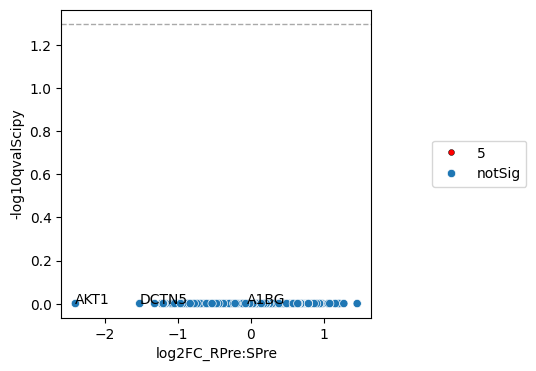

In [66]:
# make annotated volcano plot

diffExprGeneList = dfStats[dfStats['-log10qvalScipyRank'] < 1.301]['geneNamePrimary'].to_list()
diffExprGeneList.extend(dfStats[dfStats['log2FC_RPre:SPre'] < -1.5]['geneNamePrimary'].to_list())
diffExprGeneList.extend(dfStats[dfStats['log2FC_RPre:SPre'] > 2.5]['geneNamePrimary'].to_list())

mask = dfStats['geneNamePrimary'].isin(diffExprGeneList)
annotations = diffExprGeneList

diffExprGeneListAlt = dfStats[dfStats['-log10qvalScipyRank'] < 15]['geneNamePrimary'].to_list()
diffExprGeneListAlt.extend(dfStats[dfStats['log2FC_RPre:SPre'] < -5]['geneNamePrimary'].to_list())
diffExprGeneListAlt.extend(dfStats[dfStats['log2FC_RPre:SPre'] > 5]['geneNamePrimary'].to_list())

if len(diffExprGeneList) > 40:
    mask = dfStats['geneNamePrimary'].isin(diffExprGeneListAlt)
    annotations = diffExprGeneListAlt

plt.figure(figsize=(4,4))

sns.scatterplot(data = dfStats.loc[mask],
    x = 'log2FC_RPre:SPre',
    y = '-log10qvalScipy',
    size=5,
    facecolor = 'red',
    edgecolor = 'black',)

for i in annotations:
    plt.annotate(i,
        (dfStats[dfStats.geneNamePrimary == i]['log2FC_RPre:SPre'],
        dfStats[dfStats.geneNamePrimary == i]['-log10qvalScipy'],
        )
    ) 

sns.scatterplot(
    data=dfStats,
    x="log2FC_RPre:SPre",
    y="-log10qvalScipy",
    hue = 'sigFDR',
    ).axhline(
    1.3, color = 'darkgrey', linestyle = '--', linewidth=1)

plt.legend(bbox_to_anchor=(1.5, .5), loc='center right', borderaxespad=0)

plt.show()